In [1]:
from tensorflow.keras.datasets.mnist import load_data
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.layers import Reshape
from tensorflow.keras.layers import Conv2DTranspose
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import UpSampling2D


import tensorflow as tf
import csv

from numpy import expand_dims
from numpy import zeros
from numpy import ones
from numpy import vstack
from numpy.random import randn
from numpy.random import randint
import matplotlib.pyplot as plt
from datetime import datetime

In [2]:
# necessary for my 3080 GPU to ensure it performs as expected and doesn't weirdly run out of memory

config = tf.compat.v1.ConfigProto(gpu_options = 
                         tf.compat.v1.GPUOptions(per_process_gpu_memory_fraction=0.8)
# device_count = {'GPU': 1}
)
config.gpu_options.allow_growth = True
session = tf.compat.v1.Session(config=config)
tf.compat.v1.keras.backend.set_session(session)

In [3]:
# define discriminator as in assignment description
def discriminator_impl(in_shape=(28,28,1)):
    model = Sequential()
    model.add(Conv2D(64, (3,3), strides=(2, 2), padding='same', input_shape=in_shape))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dropout(0.4))
    model.add(Conv2D(64, (3,3), strides=(2, 2), padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dropout(0.4))
    model.add(Flatten())
    model.add(Dense(1, activation='sigmoid'))
    
    opt = Adam(lr=0.0002, beta_1=0.5)
    model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
    model.trainable = False
    return model

def generator_impl():
    model = Sequential()

    num_units = 7 * 7 * 192

    model.add(Dense(num_units, input_dim=100))
    
    model.add(BatchNormalization())
    model.add(LeakyReLU(alpha=0.2))

    model.add(Reshape((7,7,192)))
    
    model.add(Dropout(0.4))

    # upsampling
    model.add(UpSampling2D(size=(2, 2)))

    model.add(Conv2DTranspose(96, (5,5), strides=(1), padding='same'))

    model.add(BatchNormalization())
    model.add(LeakyReLU(alpha=0.2))

    #upsampling
    model.add(UpSampling2D(size=(2, 2)))

    #DeConv
    model.add(Conv2DTranspose(48, (5,5), strides=(1), padding='same'))

    model.add(BatchNormalization())
    model.add(LeakyReLU(alpha=0.2))

    model.add(Conv2D(24, (5,5), strides=(1), padding='same'))

    model.add(BatchNormalization())
    model.add(LeakyReLU(alpha=0.2))

    model.add(Conv2D(1, (5,5), strides=(1), padding='same'))
    
    model.add(Conv2D(1, (7,7), activation='sigmoid', padding='same'))
    return model

def gan_impl(generator, discriminator):
	# make weights in the discriminator not trainable
	discriminator.trainable = False
	# connect them
	model = Sequential()
	# add generator
	model.add(generator)
	# add the discriminator
	model.add(discriminator)
	# compile model
	opt = Adam(lr=0.0002, beta_1=0.5)
	model.compile(loss='binary_crossentropy', optimizer=opt)
	return model


In [4]:
def load_real_samples():
	# load mnist dataset
	(train_data, _), (_, _) = load_data()
	X = expand_dims(train_data, axis=-1)
	X = X.astype('float32')
	X = X / 255.0
	return X

# select real samples
def generate_real_samples(dataset, n_samples):
	ix = randint(0, dataset.shape[0], n_samples)
	X = dataset[ix]
	y = ones((n_samples, 1))
	return X, y

# generate points in latent space as input for the generator
def generate_latent_points(dim_value, n_samples):
	x_input = randn(dim_value * n_samples)
	x_input = x_input.reshape(n_samples, dim_value)
	return x_input

# use the generator to generate n fake examples, with class labels
def generate_fake_samples(g_model, dim_value, n_samples):
	# generate points in latent space
	x_input = generate_latent_points(dim_value, n_samples)
	# predict outputs
	X = g_model.predict(x_input)
	# create 'fake' class labels (0)
	y = zeros((n_samples, 1))
	return X, y

In [5]:
def summarize_performance(epoch, generator, discriminator, dataset, dim_val):
	# prepare fake examples
	x_fake, _ = generate_fake_samples(generator, dim_val, 16)
		# plot images
	for i in range(16):
		# define subplot
		plt.subplot(4, 4, 1 + i)
		# turn off axis
		plt.axis('off')
		# plot raw pixel data
		plt.imshow(x_fake[i, :, :, 0], cmap='gray')
	# save plot to file
	filename = 'generated_plot_e%03d.png' % (epoch+1)
	plt.savefig(filename)
	plt.close()

def write_to_csv(filename, loss_list):
	with open(filename, 'a+', newline='') as csvfile:
		csvwriter = csv.writer(csvfile)    
		csvwriter.writerow(loss_list)

In [6]:
# train the generator and discriminator
def train(generator, discriminator, gan, dataset, dim_value, n_epochs=100, n_batch=256):
	bat_per_epo = int(dataset.shape[0] / n_batch)
	half_batch = int(n_batch / 2)
	now = datetime.now()
	dt_string = now.strftime("%d-%m-%Y-%H-%M-%S")
	filename = f'loss-{dt_string}.csv'
	# manually enumerate epochs
	loss_array = []
	for i in range(n_epochs):
		# enumerate batches over the training set
		for j in range(bat_per_epo):
			# get randomly selected 'real' samples
			X_real, y_real = generate_real_samples(dataset, half_batch)
			# generate 'fake' examples
			X_fake, y_fake = generate_fake_samples(generator, dim_value, half_batch)
			# create training set for the discriminator
			X, y = vstack((X_real, X_fake)), vstack((y_real, y_fake))
			# update discriminator model weights
			discriminator_loss, _ = discriminator.train_on_batch(X, y)
			# prepare points in latent space as input for the generator
			X_gan = generate_latent_points(dim_value, n_batch)
			# create inverted labels for the fake samples
			y_gan = ones((n_batch, 1))
			# update the generator via the discriminator's error
			gan_loss = gan.train_on_batch(X_gan, y_gan)
			# summarize loss on this batch
			print('>%d, %d/%d' % (i+1, j+1, bat_per_epo))
			# if (j + 1) == bat_per_epo:
			# 	# loss_array.append('%.3f, %.3f' % (discriminator_loss, gan_loss))
			# 	loss_array.append([float('{:,.3f}'.format(discriminator_loss)), float('{:,.3f}'.format(gan_loss))])
			write_to_csv(filename, [float('{:,.3f}'.format(discriminator_loss)), float('{:,.3f}'.format(gan_loss))])
		# evaluate the model performance, sometimes
		if (i+1) in [1,10,20] or ((i + 1) > 100 and (i + 1) % 50 == 0):
			summarize_performance(i, generator, discriminator, dataset, dim_value)
	return loss_array

In [7]:
discriminator = discriminator_impl()
generator = generator_impl()
gan = gan_impl(generator, discriminator)
# load image data
dataset = load_real_samples()
# train model
train(generator, discriminator, gan, dataset, 100, 600)

94, 164/234
>594, 165/234
>594, 166/234
>594, 167/234
>594, 168/234
>594, 169/234
>594, 170/234
>594, 171/234
>594, 172/234
>594, 173/234
>594, 174/234
>594, 175/234
>594, 176/234
>594, 177/234
>594, 178/234
>594, 179/234
>594, 180/234
>594, 181/234
>594, 182/234
>594, 183/234
>594, 184/234
>594, 185/234
>594, 186/234
>594, 187/234
>594, 188/234
>594, 189/234
>594, 190/234
>594, 191/234
>594, 192/234
>594, 193/234
>594, 194/234
>594, 195/234
>594, 196/234
>594, 197/234
>594, 198/234
>594, 199/234
>594, 200/234
>594, 201/234
>594, 202/234
>594, 203/234
>594, 204/234
>594, 205/234
>594, 206/234
>594, 207/234
>594, 208/234
>594, 209/234
>594, 210/234
>594, 211/234
>594, 212/234
>594, 213/234
>594, 214/234
>594, 215/234
>594, 216/234
>594, 217/234
>594, 218/234
>594, 219/234
>594, 220/234
>594, 221/234
>594, 222/234
>594, 223/234
>594, 224/234
>594, 225/234
>594, 226/234
>594, 227/234
>594, 228/234
>594, 229/234
>594, 230/234
>594, 231/234
>594, 232/234
>594, 233/234
>594, 234/234
>595, 1/

[]

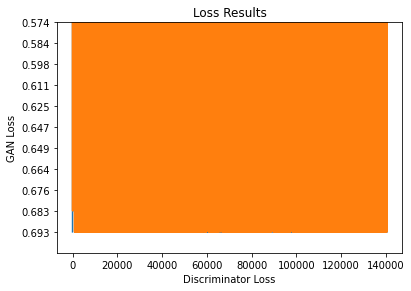

In [18]:
# import csv  

x_labels=[]
discriminator_series=[]
gan_series=[]

loss_graph = plt.figure()
axes = loss_graph.add_axes([0.1,0.1,0.8,0.8])

with open('loss-02-12-2020-07-21-34.csv', 'r') as csvfile:
    plots= csv.reader(csvfile, delimiter=',')
    rownum = 1
    for row in plots:
        # print(row)
        x_labels.append(rownum)
        discriminator_series.append(row[0])
        gan_series.append(row[1])
        rownum += 1


axes.plot(x_labels,discriminator_series)
axes.plot(x_labels,gan_series)
axes.set_ylim([0, 10])

plt.title('Loss Results')

plt.xlabel('Discriminator Loss')
plt.ylabel('GAN Loss')

plt.show()
